We will use a artificial recurrent nueral network called a LSTM (Long Short Term Memory) to predict Housing prices. I will pull data from the sql databases that I created *test changes*


In [30]:
#import Libraries
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')
import datetime
import pandas as pd
import sqlalchemy as sa
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [31]:
#need to create a connection string between the server and python
connection_string_Housing = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=Housing;Encrypt=NO;Trusted_Connection=yes"
connection_string_GDP_GROWTH = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 18 for SQL Server};SERVER=KALLESPC;DATABASE=GDP_GROWTH_1998_2024_STATE;Encrypt=NO;Trusted_Connection=yes"
engine = sa.create_engine(connection_string_Housing)

#upload,read and show table
Housing_prices_df = pd.read_sql('hpi_avg_monthly', engine)
print (Housing_prices_df.head())





     column1     avg_hpi
0 1991-01-01  100.000000
1 1991-02-01  100.355000
2 1991-03-01  100.568999
3 1991-04-01  100.460500
4 1991-05-01  100.490500


In [32]:
#Get number of rows and columns
print(Housing_prices_df.shape)
print (Housing_prices_df['avg_hpi'].max())

(411, 2)
445.5010025024414


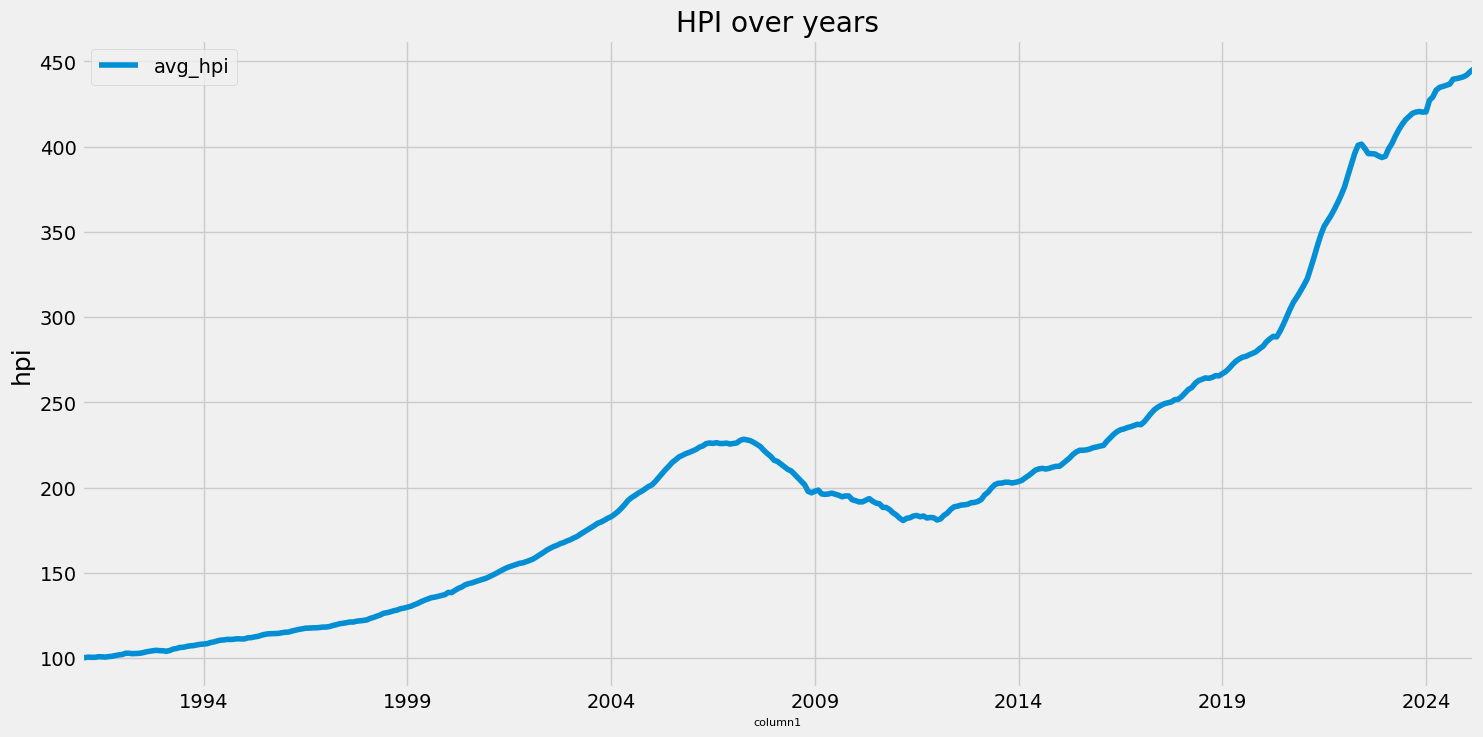

In [33]:
#Visualize the data 
#Housing_prices_df['Year'] = pd.to_datetime(Housing_prices_df['Year'])
Housing_prices_df.set_index('column1',inplace=True)
Housing_prices_df.sort_index(inplace=True)
plt.figure(figsize=(16,8))
plt.title('HPI over years')
#plt.plot(Housing_prices_df['Year'],Housing_prices_df['avg_hpi'])
plt.xlabel('Date', fontsize=8)
plt.ylabel('hpi', fontsize=18)
Housing_prices_df.plot(ax=plt.gca())
plt.show()

In [34]:
#create a new dataframe with only the "Close" column
close_stock = Housing_prices_df#.filter(['avg_hpi_year'])
#Convert the data frame to a numpy array
dataset = close_stock.to_numpy()
dataset.shape
#get the number of rows to train the model on 
Training_data_len = math.ceil(len(dataset)*.9)
Training_data_len


370

In [35]:
#Good practice to Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
#create variable to hold scaled data
print(dataset.shape)
scaled_data = scaler.fit_transform(dataset)#<----computes minimum and maximum values that are used for scaling and transforms data based on those values

scaled_data

(411, 1)


array([[0.        ],
       [0.00102749],
       [0.00164688],
       [0.00133285],
       [0.00141968],
       [0.00238928],
       [0.00217366],
       [0.00175253],
       [0.0026353 ],
       [0.00321562],
       [0.0043285 ],
       [0.00549637],
       [0.00621417],
       [0.00832704],
       [0.00821126],
       [0.00756582],
       [0.00776843],
       [0.00814035],
       [0.00910707],
       [0.01062515],
       [0.01158463],
       [0.01252529],
       [0.01330966],
       [0.01263817],
       [0.01245004],
       [0.01168882],
       [0.01295221],
       [0.01538635],
       [0.0163878 ],
       [0.01815046],
       [0.01847607],
       [0.01986825],
       [0.02088561],
       [0.02124161],
       [0.02249053],
       [0.02351079],
       [0.02388994],
       [0.02462222],
       [0.02648039],
       [0.02755564],
       [0.0292141 ],
       [0.03057878],
       [0.0309261 ],
       [0.03188124],
       [0.03167429],
       [0.03227343],
       [0.03285953],
       [0.032

In [36]:
#Create the training data set
#Create the Scaled training data set
train_data = scaled_data[0:Training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(308, len(train_data)):
    x_train.append(train_data[i-308:i,0])
    y_train.append(train_data[i,0])
    if i<=309:
        print(x_train)
        print(y_train)
        print()
#the first 229 values(x_train) are the values that will train the data to predict the 230th value(y_train)

[array([0.        , 0.00102749, 0.00164688, 0.00133285, 0.00141968,
       0.00238928, 0.00217366, 0.00175253, 0.0026353 , 0.00321562,
       0.0043285 , 0.00549637, 0.00621417, 0.00832704, 0.00821126,
       0.00756582, 0.00776843, 0.00814035, 0.00910707, 0.01062515,
       0.01158463, 0.01252529, 0.01330966, 0.01263817, 0.01245004,
       0.01168882, 0.01295221, 0.01538635, 0.0163878 , 0.01815046,
       0.01847607, 0.01986825, 0.02088561, 0.02124161, 0.02249053,
       0.02351079, 0.02388994, 0.02462222, 0.02648039, 0.02755564,
       0.0292141 , 0.03057878, 0.0309261 , 0.03188124, 0.03167429,
       0.03227343, 0.03285953, 0.03253102, 0.03267863, 0.03453535,
       0.03478427, 0.03606791, 0.03700279, 0.03891016, 0.04037615,
       0.04126037, 0.04158454, 0.04172636, 0.04202303, 0.04309105,
       0.04393475, 0.04425457, 0.04605486, 0.04735876, 0.04871911,
       0.04967569, 0.05088119, 0.05095499, 0.05143111, 0.05142387,
       0.05191012, 0.05263516, 0.05271186, 0.05355556, 0.0553

In [37]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [38]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(62, 308, 1)

In [39]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

d:\Python_programming_environment\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=100)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0392
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.4902e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.2759e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.9936e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.1409e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.5757e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.3331e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.1064e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.5828e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1643e-04
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.9853e-04
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.6741e-04
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.1855e-04
Epoch 15/

In [42]:
#Create the testing data set
test_data = scaled_data[Training_data_len - 40: , :  ]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[Training_data_len:, :]
for i in range(40, len(test_data)):
    x_test.append(test_data[i-40:i, 0])
    

In [43]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [44]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1 ))

In [45]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [46]:
#Get the root mean squared error (RMSE) it is the standard deviation of the residuals and you want lower values
rmse = np.sqrt(np.mean(predictions - y_test)**2 )
rmse

np.float64(30.576752527748663)

C:\Users\kalle\AppData\Local\Temp\ipykernel_23724\2337052924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


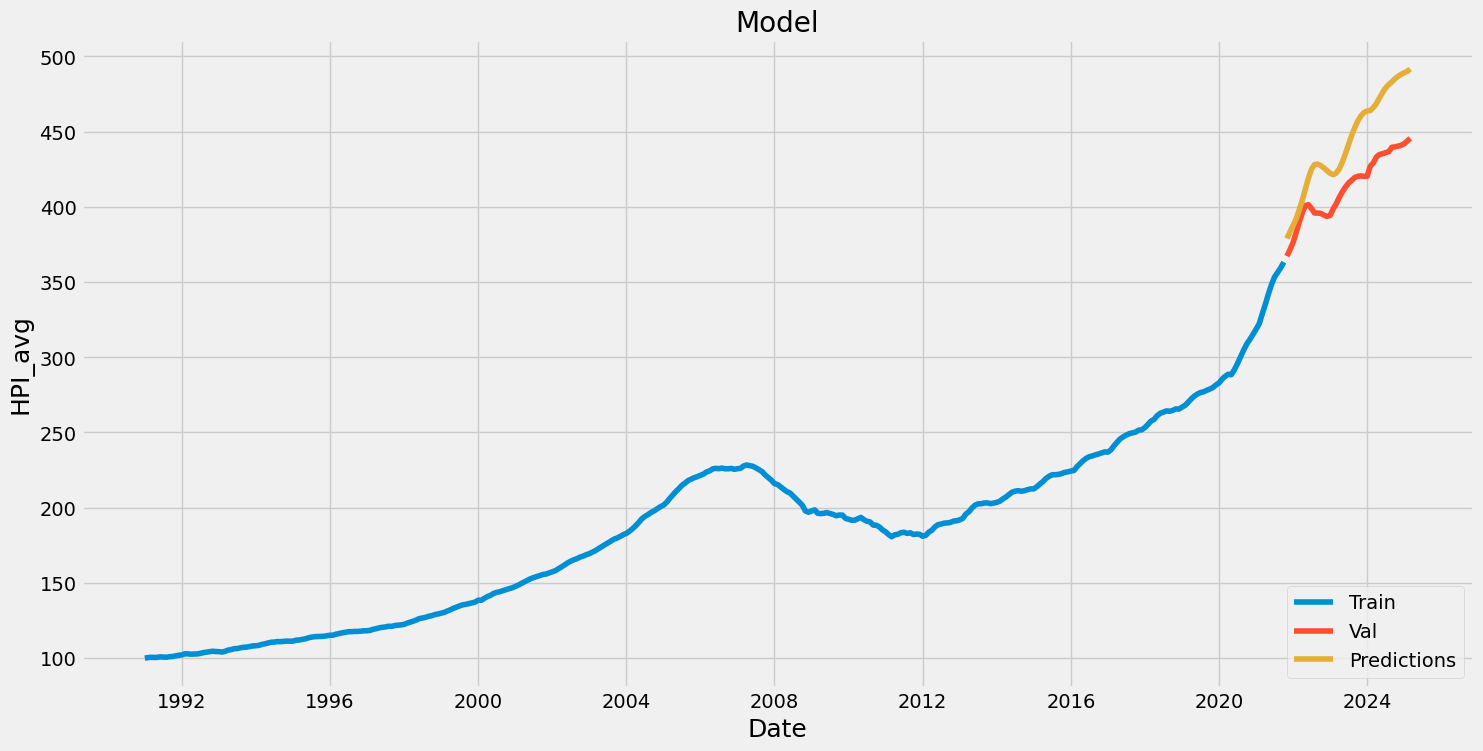

In [47]:
#Plot the data
train = Housing_prices_df[:Training_data_len]
valid = Housing_prices_df[Training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('HPI_avg', fontsize=18)
plt.plot(train['avg_hpi'])
plt.plot(valid[['avg_hpi','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [48]:
#Show the valid and predicted prices
valid

,avg_hpi,Predictions
column1,,
2021-11-01,367.210999,378.952789
2021-12-01,371.511502,383.334381
2022-01-01,376.375504,387.658447
2022-02-01,383.091502,392.263153
2022-03-01,389.563000,397.821472
2022-04-01,395.991502,404.349091
2022-05-01,400.785500,411.686462
2022-06-01,401.434000,419.111603
2022-07-01,398.893498,425.028015


In [49]:
#make predictions
future_predictions = []

# Predict N steps into the future
N = 40  # Change this to however many future months you want to predict

for _ in range(N):
    next_pred_scaled = model.predict(x_train)[0][0]
    future_predictions.append(next_pred_scaled)

    # Update the input sequence for next prediction
    next_input = np.append(x_train[0, 1:, 0], next_pred_scaled)  # drop oldest, add newest
    x_train = next_input.reshape(1, 308, 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [50]:
# Convert from scaled back to actual values
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


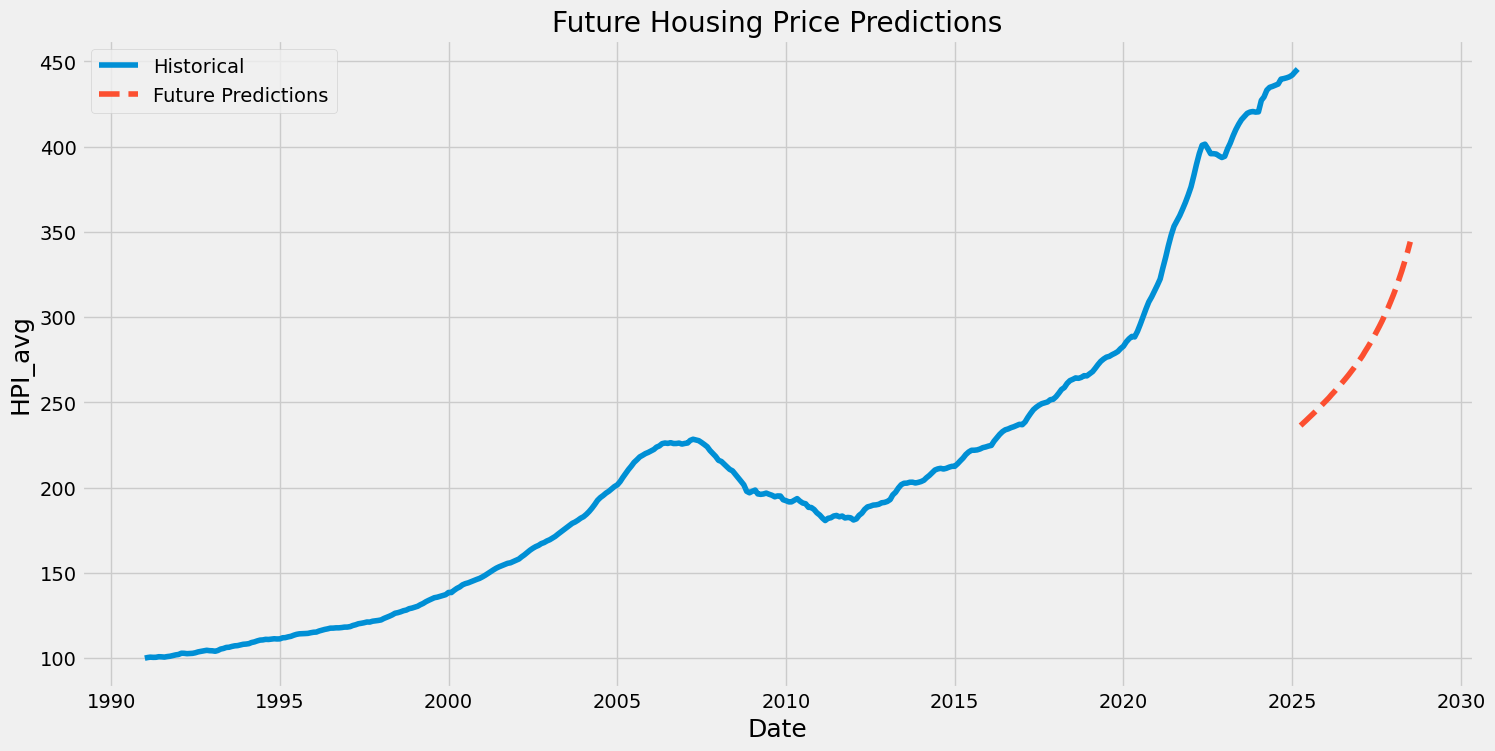

In [51]:
# Create date index for future months
last_date = Housing_prices_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=N, freq='MS')

# Build a DataFrame to store predictions
future_df = pd.DataFrame(data=future_predictions_unscaled, index=future_dates, columns=['Future_Predictions'])

# Plot historical + future
plt.figure(figsize=(16,8))
plt.title('Future Housing Price Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('HPI_avg', fontsize=18)

plt.plot(Housing_prices_df['avg_hpi'], label='Historical')
plt.plot(future_df['Future_Predictions'], label='Future Predictions', linestyle='--')
plt.legend()
plt.show()

In [54]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0
